# KITTI Dataset 분석하기

##### 여기서 나와있는 부분들은 LMS에서 따왔서 수정했습니다.

In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

print('슝=3')

슝=3


In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50% 좌우대징 
                    RandomSizedCrop(         # 50% RandizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              #224X224 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      #224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

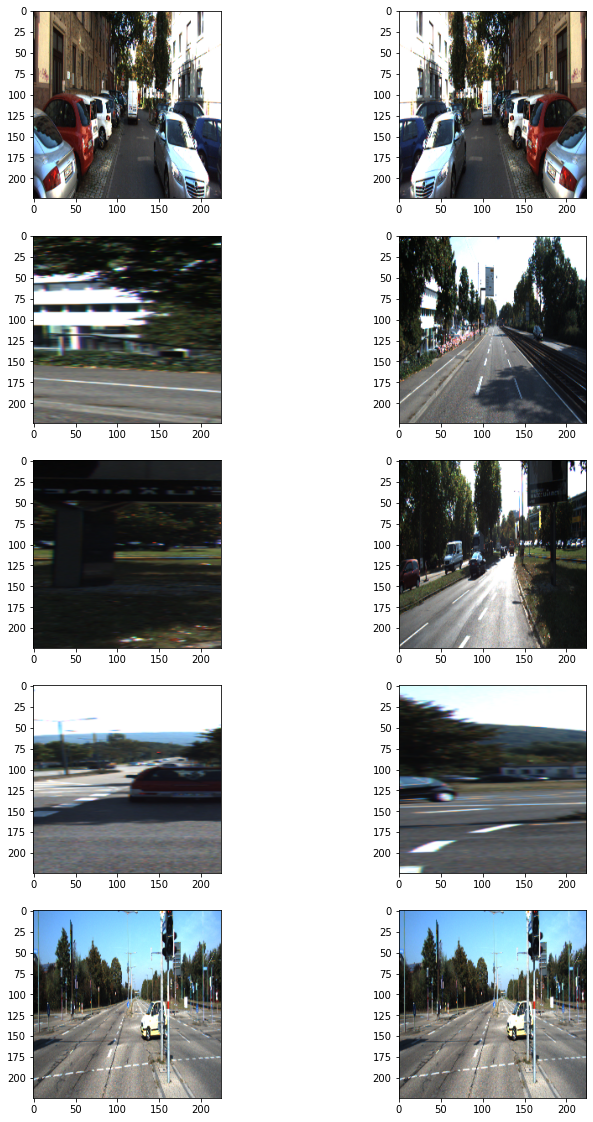

In [3]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

# UNET 찾기
### 여기서 찾을 부분: ConV2D, Upsampling2D, MaxPooling2D, Concentrate + Dropout


In [6]:
def build_unet(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)
	
  #Contracting Path
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
  
  #Expanding Path
  drop5 = Dropout(0.5)(conv5)
  up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
  up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
  up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
  up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
  conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model

In [50]:
unet = build_unet()
unet.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_177 (Conv2D)             (None, 224, 224, 64) 1792        input_12[0][0]                   
__________________________________________________________________________________________________
conv2d_178 (Conv2D)             (None, 224, 224, 64) 36928       conv2d_177[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_20 (MaxPooling2D) (None, 112, 112, 64) 0           conv2d_178[0][0]                 
___________________________________________________________________________________________

In [51]:
unet_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model = build_unet()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(unet_path) #모델을 학습한 결과.이 PATH에 저장하기

Epoch 1/100
11/11 [==============================] - 15s 1s/step - loss: 0.6873 - val_loss: 0.6682
Epoch 2/100
11/11 [==============================] - 13s 1s/step - loss: 0.5989 - val_loss: 0.2390
Epoch 3/100
11/11 [==============================] - 13s 1s/step - loss: 0.1695 - val_loss: 0.0361
Epoch 4/100
11/11 [==============================] - 13s 1s/step - loss: 0.0444 - val_loss: 0.0377
Epoch 5/100
11/11 [==============================] - 13s 1s/step - loss: 0.0392 - val_loss: 0.0360
Epoch 6/100
11/11 [==============================] - 13s 1s/step - loss: 0.0378 - val_loss: 0.0341
Epoch 7/100
11/11 [==============================] - 13s 1s/step - loss: 0.0334 - val_loss: 0.0270
Epoch 8/100
11/11 [==============================] - 13s 1s/step - loss: 0.0294 - val_loss: 0.0256
Epoch 9/100
11/11 [==============================] - 13s 1s/step - loss: 0.0302 - val_loss: 0.0328
Epoch 10/100
11/11 [==============================] - 13s 1s/step - loss: 0.0321 - val_loss: 0.0288
Epoch 11/

### > 학습한 결과, 학습 시간이 생각 보다 많이 잛다 13s. 

# UNET++ 찾기

## 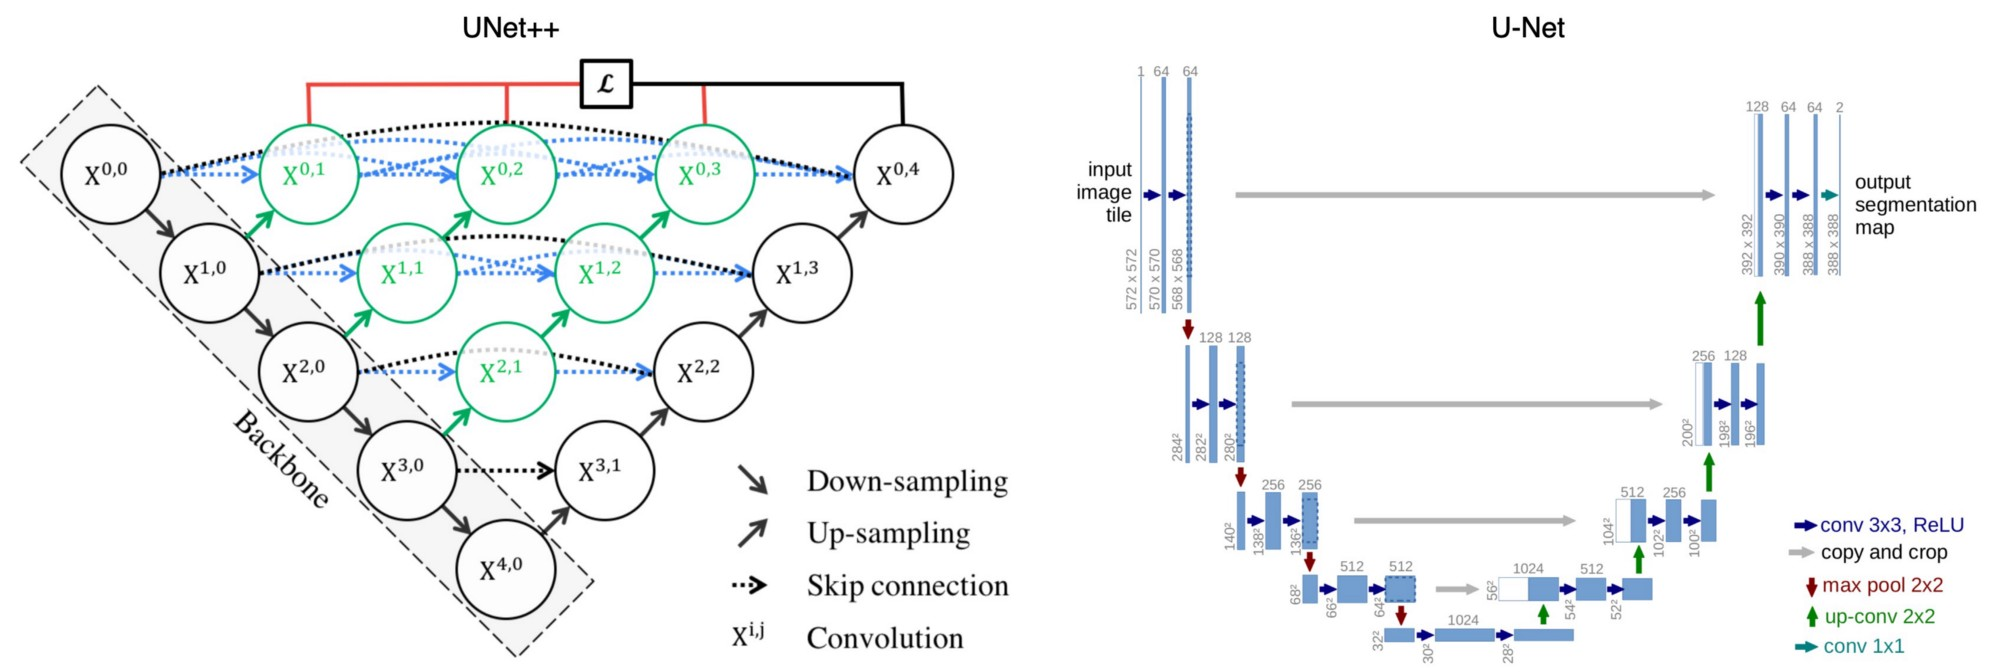

In [29]:
def build_unetPP(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)
	
  #Contracting Path
  conv1A = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1A = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1A)
  pool1A = MaxPooling2D(pool_size=(2, 2))(conv1A)
  conv2A = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1A)
  conv2A = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2A)
  pool2A = MaxPooling2D(pool_size=(2, 2))(conv2A)
  conv3A = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2A)
  conv3A = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3A)
  pool3A = MaxPooling2D(pool_size=(2, 2))(conv3A)
  conv4A = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3A)
  conv4A = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4A)
  drop4A = Dropout(0.5)(conv4A)
  pool4A = MaxPooling2D(pool_size=(2, 2))(drop4A)
  
  conv5A = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4A)  
  conv5A = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5A)
  
  #Expanding Path
  drop5A = Dropout(0.5)(conv5A)
  up6A = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5A)
  merge6A = concatenate([drop4A,up6A], axis = 3)
  conv6A = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6A)
  conv6A = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6A)
  up7A = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6A)
  merge7A = concatenate([conv3A,up7A], axis = 3)
  conv7A = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7A)
  conv7A = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7A)
  up8A = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7A)
  merge8A = concatenate([conv2A,up8A], axis = 3)
  conv8A = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8A)
  conv8A = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8A)
  up9A = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8A)
  merge9A = concatenate([conv1A,up9A], axis = 3)
  conv9A = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9A)
  conv9A = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9A)  
  conv9A = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9A)     
  conv10A = Conv2D(1, 1, activation='sigmoid')(conv9A)

  model = Model(inputs = inputs, outputs = conv10A)
  return model

In [30]:
unetPP = build_unetPP()
unetPP.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_181 (Conv2D)             (None, 224, 224, 64) 1792        input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_182 (Conv2D)             (None, 224, 224, 64) 36928       conv2d_181[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_28 (MaxPooling2D) (None, 112, 112, 64) 0           conv2d_182[0][0]                 
____________________________________________________________________________________________

In [31]:
unetPP_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model = build_unetPP()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(unetPP_path)  #여기도 UNET PLUS PLUS 저장소

Epoch 1/100
11/11 [==============================] - 15s 1s/step - loss: 0.6895 - val_loss: 0.6735
Epoch 2/100
11/11 [==============================] - 13s 1s/step - loss: 0.5992 - val_loss: 0.1042
Epoch 3/100
11/11 [==============================] - 13s 1s/step - loss: 0.0521 - val_loss: 0.0360
Epoch 4/100
11/11 [==============================] - 13s 1s/step - loss: 0.0284 - val_loss: 0.0364
Epoch 5/100
11/11 [==============================] - 13s 1s/step - loss: 0.0345 - val_loss: 0.0387
Epoch 6/100
11/11 [==============================] - 13s 1s/step - loss: 0.0373 - val_loss: 0.0338
Epoch 7/100
11/11 [==============================] - 13s 1s/step - loss: 0.0278 - val_loss: 0.0335
Epoch 8/100
11/11 [==============================] - 13s 1s/step - loss: 0.0255 - val_loss: 0.0336
Epoch 9/100
11/11 [==============================] - 13s 1s/step - loss: 0.0264 - val_loss: 0.0287
Epoch 10/100
11/11 [==============================] - 13s 1s/step - loss: 0.0303 - val_loss: 0.0484
Epoch 11/

### > 여기서 똑같다. 13s


# Segmentation 결과 검사 하고 구분하기

In [33]:
unet_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'
unetPP_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

unet = tf.keras.models.load_model(unet_path)
unet_pp = tf.keras.models.load_model(unetPP_path)

In [34]:
def get_output(model, preproc, image_path, output_path):

    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  # 0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output

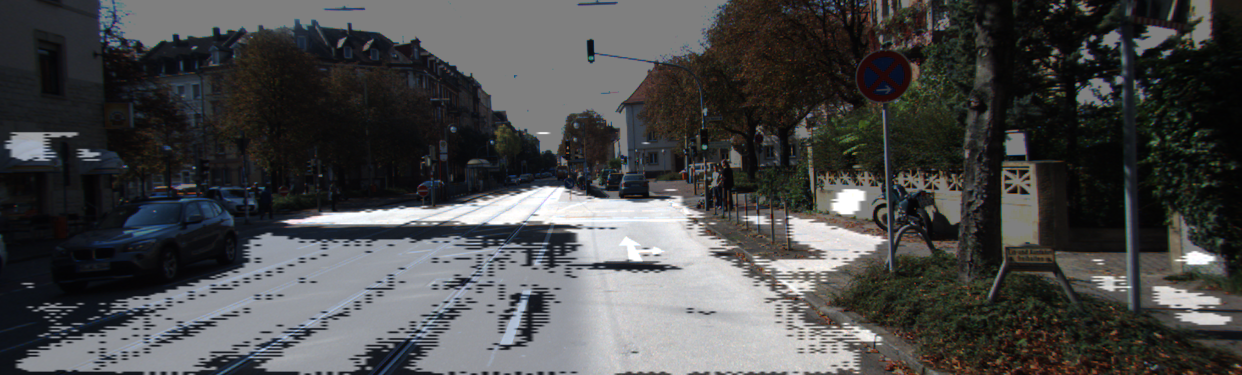

In [44]:
i = 1    
get_output(
     unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

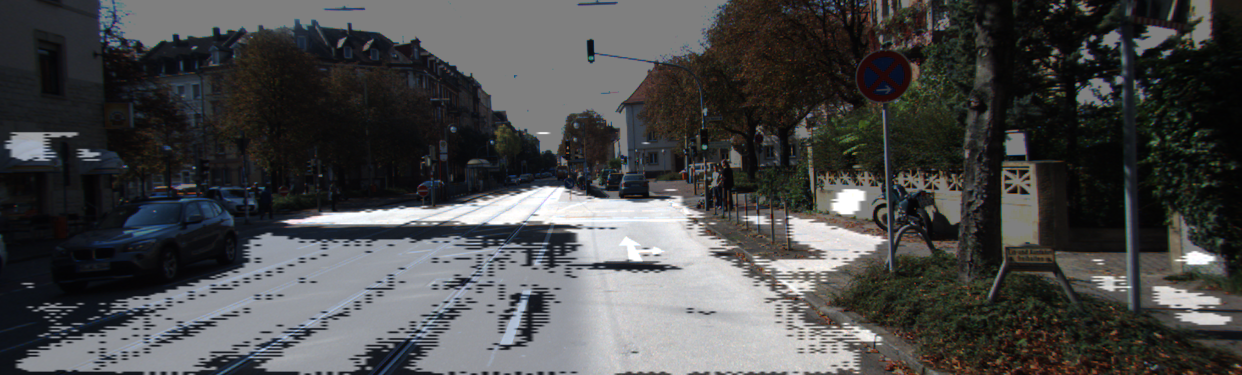

In [36]:
get_output(
     unet_pp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

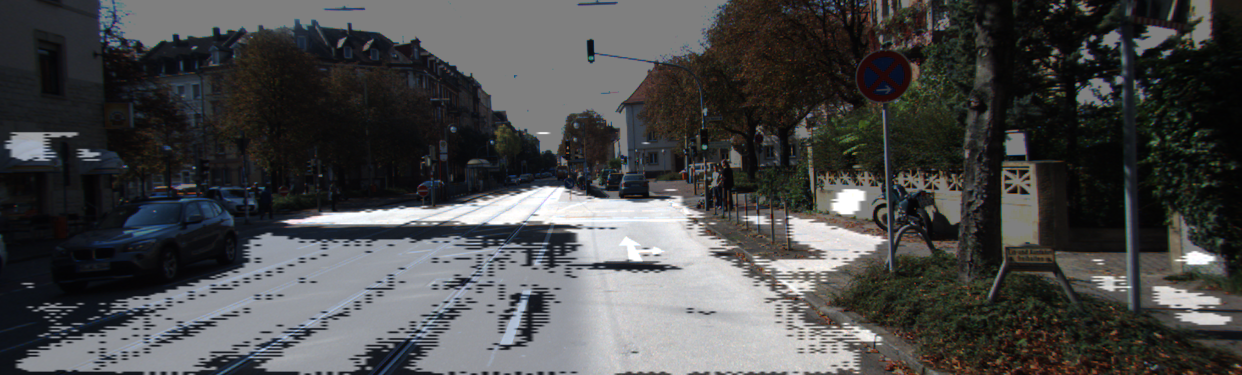

In [37]:
get_output(
     unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

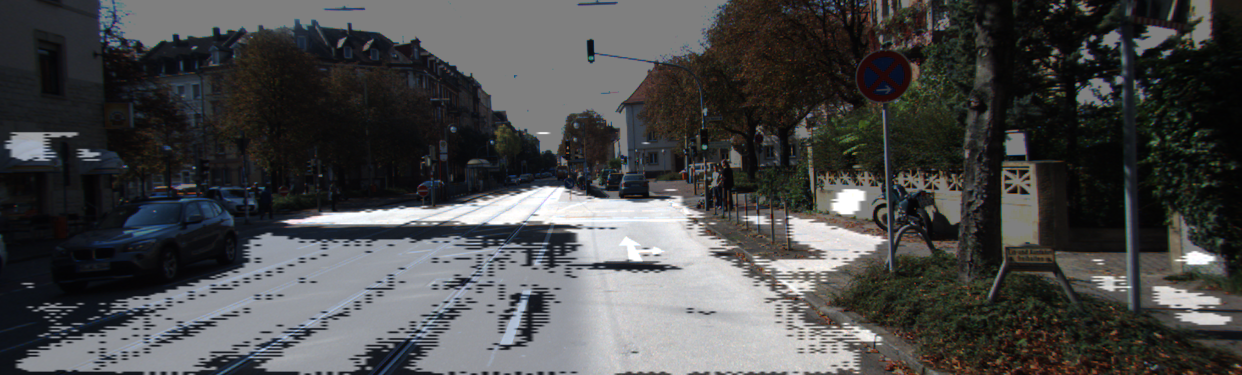

In [45]:
# 이 부분은 U-NET 결과 시각화를 의미 한다.
get_output(
     unet_pp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

### 오른쪽에 보이면 하얀색으로 된 점 보이시나요? 이게 그 U-NET 차이점이라고 저는 생각합니다.

# IoU

In [46]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [47]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255 
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()  
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [48]:
unet_iou = []
unet_pp_iou = []

for i in range(50): #먼저 이미지는 50개만 쓰겠습니다.
   
    output, prediction, target = get_output(
         unet, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )
     # UNET의 IoU 계산하기

    unet_iou.append(calculate_iou_score(target, prediction))


    output, prediction, target = get_output(
         unet_pp, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )
      
         # UNET++의 IoU 계산하기
    unet_pp_iou.append(calculate_iou_score(target, prediction))

IoU : 0.430395
IoU : 0.430395
IoU : 0.682369
IoU : 0.682369
IoU : 0.578626
IoU : 0.578626
IoU : 0.516764
IoU : 0.516764
IoU : 0.560715
IoU : 0.560715
IoU : 0.544052
IoU : 0.544052
IoU : 0.392673
IoU : 0.392673
IoU : 0.451714
IoU : 0.451714
IoU : 0.335800
IoU : 0.335800
IoU : 0.387903
IoU : 0.387903
IoU : 0.453802
IoU : 0.453802
IoU : 0.481800
IoU : 0.481800
IoU : 0.414433
IoU : 0.414433
IoU : 0.607913
IoU : 0.607913
IoU : 0.647812
IoU : 0.647812
IoU : 0.689830
IoU : 0.689830
IoU : 0.690577
IoU : 0.690577
IoU : 0.659928
IoU : 0.659928
IoU : 0.365292
IoU : 0.365292
IoU : 0.470316
IoU : 0.470316
IoU : 0.535232
IoU : 0.535232
IoU : 0.112591
IoU : 0.112591
IoU : 0.549772
IoU : 0.549772
IoU : 0.705976
IoU : 0.705976
IoU : 0.608244
IoU : 0.608244
IoU : 0.590913
IoU : 0.590913
IoU : 0.587572
IoU : 0.587572
IoU : 0.502667
IoU : 0.502667
IoU : 0.461333
IoU : 0.461333
IoU : 0.523874
IoU : 0.523874
IoU : 0.537792
IoU : 0.537792
IoU : 0.464065
IoU : 0.464065
IoU : 0.539978
IoU : 0.539978
IoU : 0.44

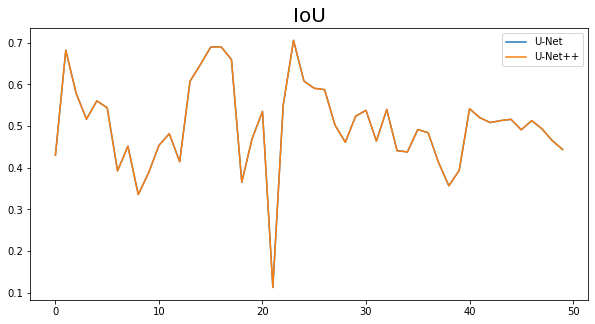

In [49]:
plt.figure(figsize=(10,5))
plt.plot(unet_iou)
plt.plot(unet_pp_iou)
plt.title('IoU', fontsize=20)
plt.legend(['U-Net', 'U-Net++'])
plt.show()

### RESULT:


#### 생각보다 결과는 재가 원하는 대로 안나왔다. 여기서 U-NET이 좀데 자세하게 나올줄알았는데. PLOT CHART에 나와있는게 없다. 

#### 여기서 다른 부분들을 비교했을떄 U-NET과 U-NET++는 비슷한 결과가 나와있는것같다. (0.2~ Loss)